In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

import pickle

# Random forest regression

In [3]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite_minute_mean_na.csv", sep=',', parse_dates=["DateTime"])

In [170]:
df.shape

(2075259, 8)

In [4]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    n_vars = data.shape[1]
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [165]:
timeframe = "3h"
delta_t_seconds=0 #nbr de secondes par time step. ex: 60*60 pour un resample('h')

timeframe = timeframe.lower()
if(timeframe == "15min"):
    delta_t_seconds = 60*15
elif(timeframe == "1h"):
    delta_t_seconds = 60*60
elif(timeframe == "3h"):
    delta_t_seconds = 60*60*3
else:
    print("Timeframe not supported")


df_rf = df.set_index('DateTime')
df_rf = df_rf.resample(timeframe).mean()
df_rf['Date'] = pd.to_datetime(df_rf.index.date)
df_rf

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,234.643889,18.100000,0.000000,0.527778,16.861111,2006-12-16
2006-12-16 18:00:00,3.433667,0.080122,233.961389,14.673333,0.000000,2.716667,16.777778,2006-12-16
2006-12-16 21:00:00,2.439400,0.068089,238.846111,10.488889,0.000000,0.211111,7.216667,2006-12-16
2006-12-17 00:00:00,2.273044,0.105867,242.409611,9.747778,0.000000,8.755556,0.000000,2006-12-17
2006-12-17 03:00:00,1.958233,0.077744,244.026389,8.368889,0.000000,0.500000,4.511111,2006-12-17
...,...,...,...,...,...,...,...,...
2010-11-26 09:00:00,1.513878,0.087022,238.948222,6.285556,2.966667,0.122222,17.522222,2010-11-26
2010-11-26 12:00:00,1.503633,0.141989,238.728000,6.325556,0.000000,0.266667,17.488889,2010-11-26
2010-11-26 15:00:00,1.223422,0.126533,239.439389,5.156667,0.000000,0.405556,7.144444,2010-11-26


In [6]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(2)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45


In [166]:
df_rf = df_rf.join(temperatures, how="left", on='Date')
df_rf = df_rf.drop(columns=['Date','avg_t', 'Voltage', 'Global_intensity'])
# df_rf = df_rf[["Global_active_power", "min_t", "max_t"]]
df_rf.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5


In [167]:
demo = df_rf.loc[(df_rf.index >= "2009-05-04 06:00:00") & (df_rf.index < "2009-05-05 06:00:00")]
demo

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,
2009-05-04 06:00:00,1.726433,0.090544,0.000000,0.188889,14.105556,9.9,14.3
2009-05-04 09:00:00,1.440911,0.102200,0.000000,0.361111,18.977778,9.9,14.3
2009-05-04 12:00:00,1.013600,0.087400,0.000000,0.183333,12.166667,9.9,14.3
2009-05-04 15:00:00,0.391389,0.101211,0.000000,0.255556,0.955556,9.9,14.3
2009-05-04 18:00:00,1.155433,0.150422,2.505556,0.288889,4.505556,9.9,14.3
2009-05-04 21:00:00,1.723822,0.096933,3.088889,0.183333,10.538889,9.9,14.3
2009-05-05 00:00:00,0.360011,0.101167,0.000000,0.366667,0.966667,7.4,16.2
2009-05-05 03:00:00,0.337833,0.083267,0.000000,0.183333,0.944444,7.4,16.2


In [8]:
print(df_rf.isnull().sum())
# df_rf.loc[df_rf['min_t'].isna()].head()

Global_active_power      0
Global_reactive_power    0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
min_t                    0
max_t                    0
dtype: int64


In [79]:
# df_rf["Hour"] = df_rf.index.hour + df_rf.index.minute/60 #here these columns are going to be scaled
# df_rf["Day"] = df_rf.index.dayofweek
# df_rf["Month"] = df_rf.index.month

scaler = MinMaxScaler(feature_range=(-1,1))
df_rf[df_rf.columns] = scaler.fit_transform(df_rf)
df_rf.head()


df_rf["Hour"] = df_rf.index.hour + df_rf.index.minute/60 #here these columns are not scaled
df_rf["Day"] = df_rf.index.dayofweek
df_rf["Month"] = df_rf.index.month

df_rf.describe()

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
count,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000
mean,-0.652902,-0.581935,-0.913692,-0.922883,-0.352936,0.141051,0.021381,10.501951,2.999133,6.451132
std,0.287086,0.179776,0.196272,0.188236,0.611017,0.361468,0.379395,6.874445,2.000087,3.416216
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000
25%,-0.902554,-0.702033,-1.000000,-0.986801,-0.873678,-0.117460,-0.258228,6.000000,1.000000,3.000000
50%,-0.711277,-0.624265,-1.000000,-0.980201,-0.544797,0.155556,0.032911,12.000000,3.000000,6.000000
75%,-0.472789,-0.521939,-0.997007,-0.968652,0.106566,0.441270,0.316456,18.000000,5.000000,9.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,6.000000,12.000000


In [80]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
validation_size = 0.03

df_val = None
if(validation_size != 0.0):
    n_rows_val_set = round(df_rf.shape[0]*validation_size)
    print(f"Taille du validation set : {n_rows_val_set}")

    df_val = df_rf.iloc[-n_rows_val_set:]
    df_rf = df_rf.iloc[:-n_rows_val_set]
    print("Train set shape : ", df_val.shape)
    print("Validation set shape : ", df_rf.shape)

# df_val = df_rf.loc[df_rf.index >= "2010-11-15"]
# df_val.shape[0]

# df_rf = df_rf.loc[df_rf.index < "2010-11-15"]

Taille du validation set : 346
Train set shape :  (346, 10)
Validation set shape :  (11185, 10)


In [ ]:
def create_train_model(model_type, df_rf, y_col="Global_active_power", train_size = 0.8, shuffle=True, n_estimators=500, learning_rate=0.1):
    df = data_to_supervised(df_rf, y_col)
    y_col = y_col + '(t)'
    X = df.copy().drop(columns=[y_col])
    y = df[y_col]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=train_size, shuffle=shuffle, random_state = 1)

    model = None
    if(model_type == "RandomForestRegressor"):
        model = RandomForestRegressor(n_estimators = n_estimators, random_state = 1)
    elif(model_type == "GradientBoostingRegressor"):
        model = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate=learning_rate, random_state = 1)
    model.fit(train_X, train_y)

    ypred = model.predict(test_X)
    
    r2 = r2_score(test_y, ypred)
    r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
    mse = mean_squared_error(test_y, ypred)
    rmse = np.sqrt(mse)

    scores = {}
    scores['r2'] = r2
    scores['r_adjusted'] = r_adjusted
    scores['mse'] = mse
    scores['rmse'] = rmse

    return model, scores

In [ ]:
# #test of function above
# model, scores = create_train_model("RandomForestRegressor", df_rf, 'Global_active_power', train_size = 0.7, shuffle=True, n_estimators=500)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

In [ ]:
# #test of function above
# model, scores = create_train_model("RandomForestRegressor", df_rf, 'Global_active_power', train_size = 0.7, shuffle=True, n_estimators=500)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

In [ ]:
# #test of function above
# model, scores = create_train_model("RandomForestRegressor", df_rf, 'Global_active_power', train_size = 0.7, shuffle=True, n_estimators=500, learning_rate=0.12)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

In [ ]:
# val_X = df_val.copy()#.drop(columns=["Global_active_power"])
# names = [col + "(t-1)" for col in val_X.columns]
# val_X.columns = names
# val_y = df_val["Global_active_power"]
# val_ypred = model.predict(val_X)
# val_ypred = np.insert(val_ypred, 0, np.nan)
# val_ypred


# nbr_steps = 300
# aa=[x for x in range(nbr_steps)]
# plt.figure(figsize=(40,10))
# plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
# plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
# plt.ylabel(df.columns[1], size=15)
# plt.xlabel('Time steps', size=15)
# plt.legend(fontsize=15)
# plt.show()

In [ ]:
def create_models_all_var(model_type, df_rf, train_size=0.8, shuffle=True, n_estimators=500, learning_rate=0.1, verbose=False):
    non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
    models = {}
    for col in df_rf.columns:
        if(col not in non_predictable_vars):
            if(verbose):
                print(f"Training a model on predicting the {col} variable")
            model, scores = create_train_model(model_type, df_rf, col, train_size, shuffle, n_estimators, learning_rate)
            model_and_scores = {}
            model_and_scores["model"] = model
            model_and_scores["scores"] = scores
            models[col] = model_and_scores

    return models

In [ ]:
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
models = create_models_all_var(model_type[0], df_rf, train_size=0.999, shuffle=True, n_estimators=500, learning_rate=0.12, verbose=True)

In [ ]:
#scores of models trained above
for variable in models.keys():
    print(f"\nScores for the model trained to predict {variable}:")
    print(f"R-squared: {models[variable]['scores']['r2']}")
    print(f"Adjusted R-squared: {models[variable]['scores']['r_adjusted']}")
    print(f"Test MSE: {models[variable]['scores']['mse']}")
    print(f"Test RMSE: {models[variable]['scores']['rmse']}")

In [11]:
def predict_all_variables(models, x_row, temperatures, timesteps_forward=1, delta_t_seconds=60*60*1):
    date = datetime.datetime.fromisoformat(str(x_row.index[0]))

    rows = x_row.copy()
    names = [col + "(t-1)" for col in rows.columns]
    rows.columns = names
    for i in range(timesteps_forward):
        date = date + datetime.timedelta(seconds=delta_t_seconds)
        prediction = []
        for model_name in models.keys():
            last_line = pd.DataFrame(rows.iloc[rows.shape[0]-1]).transpose()
            prediction.append(models[model_name].predict(last_line)[0])
        prediction.append(temperatures.loc[str(date)]["min_t"])
        prediction.append(temperatures.loc[str(date)]["max_t"])
        prediction.append(date.hour + date.minute/60)
        prediction.append(date.weekday())
        prediction.append(date.month)

        prediction = pd.Series(prediction, index = names)
        rows = rows.append(prediction, ignore_index=True)

    rows = rows.drop(index=0)#drop thefirst initial row, used to start the predictions
    return rows

In [12]:
def forecast(initial_row, temperatures_predictions, model_type = "RandomForestRegressor", timesteps_forward=1, timeframe="3h"):
    delta_t_seconds=0
    timeframe = timeframe.lower()
    if(timeframe == "15min"):
        delta_t_seconds = 60*15
    elif(timeframe == "1h"):
        delta_t_seconds = 60*60
    elif(timeframe == "3h"):
        delta_t_seconds = 60*60*3
    else:
        print("Timeframe not supported")
        return 0
    
    models = {}
    for var in initial_row.columns:
        non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
        if(var not in non_predictable_vars):
            try:
                models[var] = pickle.load(open(f'models/{timeframe}/{model_type}/{var}.pkl', 'rb'))
            except:
                print(f"Model for variable {var} was not found on disk.")
                return 0
    
    predictions = predict_all_variables(models, initial_row, temps, nbr_pred, delta_t_seconds)

    return predictions

In [13]:
def forecast_from_row_dataset(initial_date, df, temperatures, model_type = "RandomForestRegressor", timesteps_forward=1, timeframe="3h"):
    initial_date = str(datetime.datetime.fromisoformat(initial_date))#je passe en datetime uniquement pour verifier que la date est bien à un format valide. ça levera une exception sinon
    if(not initial_date in df.index):
        print(f"The date given ({initial_date}) was not found in the dataset")
    initial_row = pd.DataFrame(df.loc[initial_date]).transpose()

    predictions = forecast(initial_row, temperatures, model_type=model_type, timesteps_forward=timesteps_forward, timeframe=timeframe)
    
    return predictions

In [161]:
# indice_inicial_row = 21
nbr_pred = 12 #24*5
initial_date = "2009-05-04 06:00:00"
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
temps = df_rf[["min_t", "max_t"]]
predictions = forecast_from_row_dataset(initial_date, df_rf, temps, model_type[0], nbr_pred, timeframe)

In [ ]:
# temps = df_val[["min_t", "max_t"]]
# temps = df_rf[["min_t", "max_t"]]
# predictions = predict_all_variables(models, initial_date, temps, nbr_pred, delta_t_seconds)
# predictions.head()

In [162]:
initial_date_dt = datetime.datetime.fromisoformat(initial_date)
y = df_rf.loc[(df_rf.index >= str(initial_date_dt)) & (df_rf.index < str(initial_date_dt+datetime.timedelta(seconds=delta_t_seconds*(nbr_pred+1))))]["Global_active_power"]
# inv_y = df_val.iloc[indice_inicial_row:indice_inicial_row+nbr_pred+1]["Global_active_power"]
yhat = predictions["Global_active_power(t-1)"]
yhat = pd.concat([pd.Series([np.nan]), yhat])
# inv_y = df_val["Sub_metering_1"]
# inv_yhat = predictions["Sub_metering_1(t-1)"]

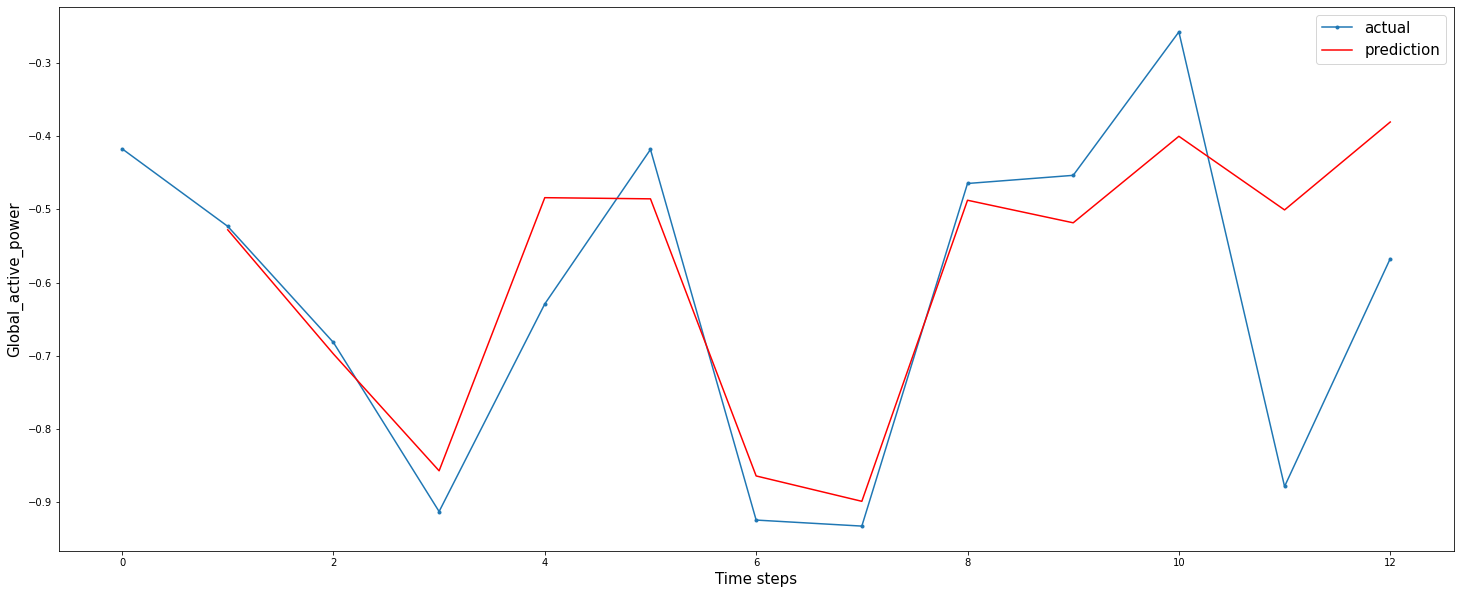

In [163]:
nbr_steps = len(yhat)
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(25,10))
plt.plot(aa, y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel(f'Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

In [18]:
#Scores of this recursive prediciton :
y = y.drop(y.index[0])
yhat = yhat.drop(yhat.index[0])

# r2 = r2_score(y, yhat)
# r_adjusted = 1 - ( 1-r2 ) * ( len(y) - 1 ) / ( len(y) - initial_row.shape[1] - 1 )
mse = mean_squared_error(y, yhat)
rmse = np.sqrt(mse)

scores = {}
# scores['r2'] = r2
# scores['r_adjusted'] = r_adjusted
scores['mse'] = mse
scores['rmse'] = rmse

# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
print(f"Test MSE: {scores['mse']}")
print(f"Test RMSE: {scores['rmse']}")

Test MSE: 0.00561651858407472
Test RMSE: 0.07494343589717994


In [23]:
val_X = df_val.copy()#.drop(columns=["Global_active_power"])
names = [col + "(t-1)" for col in val_X.columns]
val_X.columns = names
val_y = df_val["Global_active_power"]
val_y = val_y.append(pd.Series([np.nan]))
val_ypred = models["Global_active_power"]["model"].predict(val_X)
val_ypred = np.insert(val_ypred, 0, np.nan)
val_ypred


# nbr_steps = 25
nbr_steps = len(val_ypred)
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

NameError: name 'models' is not defined

In [ ]:
#serialize models
model_type = models[list(models.keys())[0]]['model'].__class__.__name__
path = f"models/{timeframe}/{model_type}/"
for variable in models.keys():
    if(not os.path.exists(path)):
        os.makedirs(path)
    filename =f"{path}{variable}.pkl"
    pickle.dump(models[variable]["model"], open(filename, 'wb'))
    print(f"'{variable}' predicting model saved on disk as {filename}")

In [ ]:
#serialize scaler
filename =f"{path}scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'))
print(f"Scaler saved on disk as {filename}")

In [ ]:
#descaling
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
variable_to_predict = "Global_active_power"

model = pickle.load(open(f'models/{timeframe}/{model_type[0]}/{variable_to_predict}.pkl', 'rb'))
scaler = pickle.load(open(f'models/{timeframe}/{model_type[0]}/scaler.pkl', 'rb'))


In [ ]:
pred_row_scaled = pd.DataFrame(columns=scaler.feature_names_in_)
pred_row = [0]*len(pred_row_scaled.columns)
pred_row[0] = 0
pred_row = pd.Series(pred_row, index = pred_row_scaled.columns)
pred_row_scaled = pred_row_scaled.append(pred_row, ignore_index=True)
pred_row_scaled

In [ ]:
pred_row_unscaled = scaler.inverse_transform(pred_row_scaled)
print(pred_row_unscaled)

In [ ]:
print(scaler.feature_names_in_)

In [ ]:
# model_and_score = pickle.load(open(f'models/{timeframe}/{model_type[0]}/Global_active_power.pkl', 'rb'))
# print(model_and_score.keys())
# print(model_and_score["model"])
# print(model_and_score["scores"])

In [ ]:
# size = df_rf.shape[1]-1
# test_X["ypred"] = ypred
# test_X
# ypred = ypred.reshape(-1,1)
# ypred = scaler.inverse_transform(test_X)["ypred"]
# # test_y = scaler.inverse_transform(test_y)

# inv_yhat = np.concatenate((ypred, test_X[:, 1-size:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# descaler = MinMaxScaler()
# descaler.min_,descaler.scale_=scaler.min_[0],scaler.scale_[0]
# ypred = descaler.inverse_transform(ypred)

In [ ]:
df_rf = data_to_supervised(df_rf)
values = df_rf.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(5*24, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
# model.add(LSTM(5*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=23, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
size = df_rf.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
test_y

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

In [ ]:
nbr_steps = 50
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()